In [31]:
from __future__ import print_function
import os
import sys
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

dfdata = os.getenv("DFDATA")
puiData = os.getenv("PUIDATA")
# Directory for demographic statics data
datdir = dfdata + "/kku6-nxdu/1414245945"
datfile = datdir + "/kku6-nxdu"
"""
Notebook will be using the following columns from demographic statistics file
13: Percent Hispanic/Latino
31: Percent US Citizen

In addition, the field "Count Participants" is used to weight the rows, identified as
1: Total
"""
df = pd.read_csv(datfile, usecols = [1, 13, 31], skiprows=1,
                 names = ["Total", "Pct Hisp", "Pct Citizen"],
                dtype = {"Total" : np.int, "Pct Hisp" : np.float, "Pct Citizen" : np.float})
subdf = df.loc[df["Total"] > 2]
selection = subdf.head(10)
selection

,Total,Pct Hisp,Pct Citizen
0,44,0.36,0.95
1,35,0.03,0.94
5,6,0.33,1.00
9,3,0.33,1.00
11,8,0.00,1.00
13,17,0.53,1.00
15,3,0.00,0.67
20,7,0.43,1.00
21,4,0.00,1.00
22,27,0.56,0.89


In [85]:
#import statsmodels.api as sma
#import statsmodels.regression.linear_model as slm
#
#import ing statsmodels.api and other statsmodels modules was not working,
#so I got around that by manaually conducting a GLS of PctCitizen on PctHisp using
#Total as a weighting field.

#If importing statsmodels.regression had worked, this would have created the GLS regression
#results
#gls_mod = slm.GLS(subdf["Pct Citizen"], subdf["Pct Hisp"], np.diagonal(subdf["Total"]))
from numpy.linalg import inv
numrows = subdf.shape
numrows = numrows[0]
#Instead, this had to be done manually
#X was ([1], subdf[Pct Hisp])
#Omega was a diagonal matrix of (subdf[Total])
#Y was (subdf[Pct Citizen])
#Coeffients were calculated as (X^T * Omega * X)^{-1} * X^T * Omega * Y
onevec = np.ones(subdf.shape[0], float)
depvar = np.array(subdf["Pct Citizen"])
depvarT = np.transpose(depvar)
indvar = np.array(subdf["Pct Hisp"])
indvarmat = np.column_stack((onevec, indvar))
indvarT = np.transpose(indvarmat)
omegamat = np.diag(subdf["Total"])
omega_dep = np.dot(omegamat, depvar)
omega_ind = np.dot(omegamat, indvarmat)
omega_indT = np.transpose(omega_ind)
ind2 = np.dot(indvarT, omega_ind)
depind = np.dot(indvarT, omega_dep)
betahat = np.dot(inv(ind2), depind)
betahat

array([ 0.98450504, -0.10657987])

Populating the interactive namespace from numpy and matplotlib


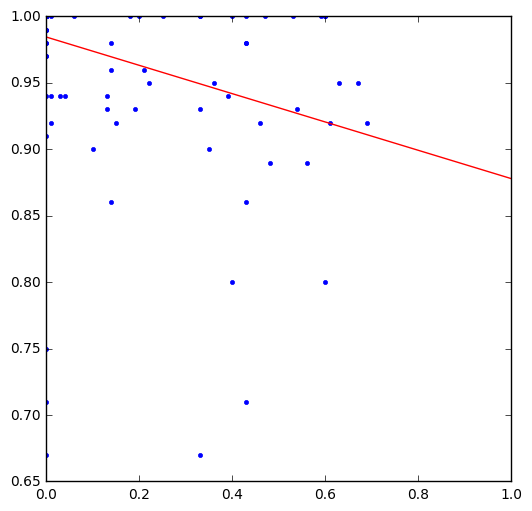

In [87]:
import pylab as pl
%pylab inline
fig = pl.figure(figsize=(6, 6))
pl.plot(subdf["Pct Hisp"], subdf["Pct Citizen"], "b.")
pl.plot([0, 1], [betahat[0], betahat[0] + betahat[1]], "r-")

# Figure 1

Scatter plot of propotion of the population Hispanic/Latino (HISP) on the x-axis and the proportion of population US Citizens (CIT). The red line shows a weighted regression by the total number of respondents in each area, showing that CIT = 0.98 - 0.11 * HISP